# Proyecto final Machine Learning
Sistema para la predicción de diabetes utilizando la base de datos 'CDC Diabetes Health Indicators'

## Librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from google.colab import files

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix
from yellowbrick.classifier import ClassificationReport, ClassPredictionError, ROCAUC
import warnings
import seaborn as sns
!pip install ydata-profiling

from ydata_profiling import ProfileReport

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.0 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=78080e00a41c14662dfd06141e909e4b913e9642d6e8ec5feafad8d18151fd75
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


## Lectura del Dataset

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"carlosamacias","key":"59bbf8cae4f308761bc1d2b1954ce70f"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d alexteboul/diabetes-health-indicators-dataset --unzip
!ls # Revisión de archivos descargados

Dataset URL: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset
License(s): CC0-1.0
  0% 0.00/6.03M [00:00<?, ?B/s]
100% 6.03M/6.03M [00:00<00:00, 796MB/s]
diabetes_012_health_indicators_BRFSS2015.csv		   kaggle.json
diabetes_binary_5050split_health_indicators_BRFSS2015.csv  sample_data
diabetes_binary_health_indicators_BRFSS2015.csv


In [6]:
data = pd.read_csv('/content/diabetes_binary_health_indicators_BRFSS2015.csv')
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

Diabetes_binary         HighBP       HighChol      CholCheck  \
count    253680.000000  253680.000000  253680.000000  253680.000000   
mean          0.139333       0.429001       0.424121       0.962670   
std           0.346294       0.494934       0.494210       0.189571   
min           0.000000       0.000000       0.000000       0.000000   
25%           0.000000       0.000000       0.000000       1.000000   
50%           0.000000       0.000000       0.000000       1.000000   
75%           0.000000       1.000000       1.000000       1.000000   
max           1.000000       1.000000       1.000000       1.000000   

                 BMI         Smoker         Stroke  HeartDiseaseorAttack  \
count  253680.000000  253680.000000  253680.000000         253680.000000   
mean       28.382364       0.443169       0.040571              0.094186   
std         6.608694       0.496761       0.197294              0.292087   
min        12.000000       0.000000       0.000000              0.000000   
25%        24.000000       0.000000       0.000000              0.000000   
50%        27.000000       0.000000       0.000000              0.000000   
75%        31.000000       1.000000       0.000000              0.000000   
max        98.000000       1.000000       1.000000              1.000000   

        PhysActivity         Fruits  ...  AnyHealthcare    NoDocbcCost  \
count  253680.000000  253680.000000  ...  253680.000000  253680.000000   
mean        0.756544       0.634256  ...       0.951053       0.084177   
std         0.429169       0.481639  ...       0.215759       0.277654   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         1.000000       0.000000  ...       1.000000       0.000000   
50%         1.000000       1.000000  ...       1.000000       0.000000   
75%         1.000000       1.000000  ...       1.000000       0.000000   
max         1.000000       1.000000  ...       1.000000       1.000000   

             GenHlth       MentHlth       PhysHlth       DiffWalk  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean        2.511392       3.184772       4.242081       0.168224   
std         1.068477       7.412847       8.717951       0.374066   
min         1.000000       0.000000       0.000000       0.000000   
25%         2.000000       0.000000       0.000000       0.000000   
50%         2.000000       0.000000       0.000000       0.000000   
75%         3.000000       2.000000       3.000000       0.000000   
max         5.000000      30.000000      30.000000       1.000000   

                 Sex            Age      Education         Income  
count  253680.000000  253680.000000  253680.000000  253680.000000  
mean        0.440342       8.032119       5.050434       6.053875  
std         0.496429       3.054220       0.985774       2.071148  
min         0.000000       1.000000       1.000000       1.000000  
25%         0.000000       6.000000       4.000000       5.000000  
50%         0.000000       8.000000       5.000000       7.000000  
75%         1.000000      10.000000       6.000000       8.000000  
max         1.000000      13.000000       6.000000       8.000000  

[8 rows x 22 columns]

### Información general del dataset

In [ ]:
# Dimensiones del dataset
print(f"Número de filas y columnas: {data.shape}")

# Tipos de datos
data.info()

# Estadísticas generales
data.describe().T


Número de filas y columnas: (253680, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth    

count       mean       std   min   25%   50%   75%  \
Diabetes_binary       253680.0   0.139333  0.346294   0.0   0.0   0.0   0.0   
HighBP                253680.0   0.429001  0.494934   0.0   0.0   0.0   1.0   
HighChol              253680.0   0.424121  0.494210   0.0   0.0   0.0   1.0   
CholCheck             253680.0   0.962670  0.189571   0.0   1.0   1.0   1.0   
BMI                   253680.0  28.382364  6.608694  12.0  24.0  27.0  31.0   
Smoker                253680.0   0.443169  0.496761   0.0   0.0   0.0   1.0   
Stroke                253680.0   0.040571  0.197294   0.0   0.0   0.0   0.0   
HeartDiseaseorAttack  253680.0   0.094186  0.292087   0.0   0.0   0.0   0.0   
PhysActivity          253680.0   0.756544  0.429169   0.0   1.0   1.0   1.0   
Fruits                253680.0   0.634256  0.481639   0.0   0.0   1.0   1.0   
Veggies               253680.0   0.811420  0.391175   0.0   1.0   1.0   1.0   
HvyAlcoholConsump     253680.0   0.056197  0.230302   0.0   0.0   0.0   0.0   
AnyHealthcare         253680.0   0.951053  0.215759   0.0   1.0   1.0   1.0   
NoDocbcCost           253680.0   0.084177  0.277654   0.0   0.0   0.0   0.0   
GenHlth               253680.0   2.511392  1.068477   1.0   2.0   2.0   3.0   
MentHlth              253680.0   3.184772  7.412847   0.0   0.0   0.0   2.0   
PhysHlth              253680.0   4.242081  8.717951   0.0   0.0   0.0   3.0   
DiffWalk              253680.0   0.168224  0.374066   0.0   0.0   0.0   0.0   
Sex                   253680.0   0.440342  0.496429   0.0   0.0   0.0   1.0   
Age                   253680.0   8.032119  3.054220   1.0   6.0   8.0  10.0   
Education             253680.0   5.050434  0.985774   1.0   4.0   5.0   6.0   
Income                253680.0   6.053875  2.071148   1.0   5.0   7.0   8.0   

                       max  
Diabetes_binary        1.0  
HighBP                 1.0  
HighChol               1.0  
CholCheck              1.0  
BMI                   98.0  
Smoker                 1.0  
Stroke                 1.0  
HeartDiseaseorAttack   1.0  
PhysActivity           1.0  
Fruits                 1.0  
Veggies                1.0  
HvyAlcoholConsump      1.0  
AnyHealthcare          1.0  
NoDocbcCost            1.0  
GenHlth                5.0  
MentHlth              30.0  
PhysHlth              30.0  
DiffWalk               1.0  
Sex                    1.0  
Age                   13.0  
Education              6.0  
Income                 8.0

El data set consta de 21 campos incluido la variable objetivo (Diabetes_binary). En total son 253680 registros entre varaibles que especifican estilo de vida, habitos de salud, ambiente social entre otras. El data set no tiene registros nulos o información faltante.

### Revisando y elimiando filas duplicadas

In [7]:
duplicates = data[data.duplicated()]
print("Duplicate Rows : ",len(duplicates))
duplicates.head()

Duplicate Rows :  24206


Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
1242              1.0     1.0       1.0        1.0  27.0     1.0     0.0   
1563              0.0     0.0       0.0        1.0  21.0     1.0     0.0   
2700              0.0     0.0       0.0        1.0  32.0     0.0     0.0   
3160              0.0     0.0       0.0        1.0  21.0     0.0     0.0   
3332              0.0     0.0       0.0        1.0  24.0     0.0     0.0   

      HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
1242                   0.0           0.0     0.0  ...            1.0   
1563                   0.0           1.0     1.0  ...            1.0   
2700                   0.0           1.0     1.0  ...            1.0   
3160                   0.0           1.0     1.0  ...            1.0   
3332                   0.0           1.0     1.0  ...            1.0   

      NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  \
1242          0.0      5.0       0.0      30.0       1.0  0.0  10.0   
1563          0.0      1.0       0.0       0.0       0.0  0.0   4.0   
2700          0.0      2.0       0.0       0.0       0.0  0.0   5.0   
3160          0.0      1.0       0.0       0.0       0.0  0.0   4.0   
3332          0.0      1.0       0.0       0.0       0.0  1.0   9.0   

      Education  Income  
1242        4.0     5.0  
1563        6.0     8.0  
2700        6.0     8.0  
3160        6.0     8.0  
3332        6.0     8.0  

[5 rows x 22 columns]

In [ ]:
# Eliminando 24206 filas duplicadas
data.drop_duplicates(inplace = True)

### Distribución de la variable objetivo

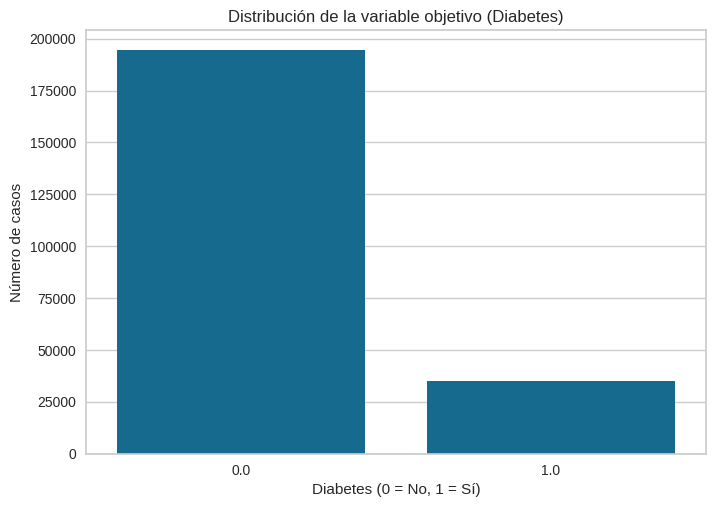

In [ ]:
sns.countplot(x='Diabetes_binary', data=data)
plt.title('Distribución de la variable objetivo (Diabetes)')
plt.xlabel('Diabetes (0 = No, 1 = Sí)')
plt.ylabel('Número de casos')
plt.show()

La variable objetivo se encuentra altamente desbalanceada en donde se clasifica como 0 a las personas que no tienen diabetes y 1 a las personas que si tienen.

### Detección de datos faltantes

In [ ]:
data.isnull().sum()


Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

No hay registros faltantes

### Visualización de correlaciones

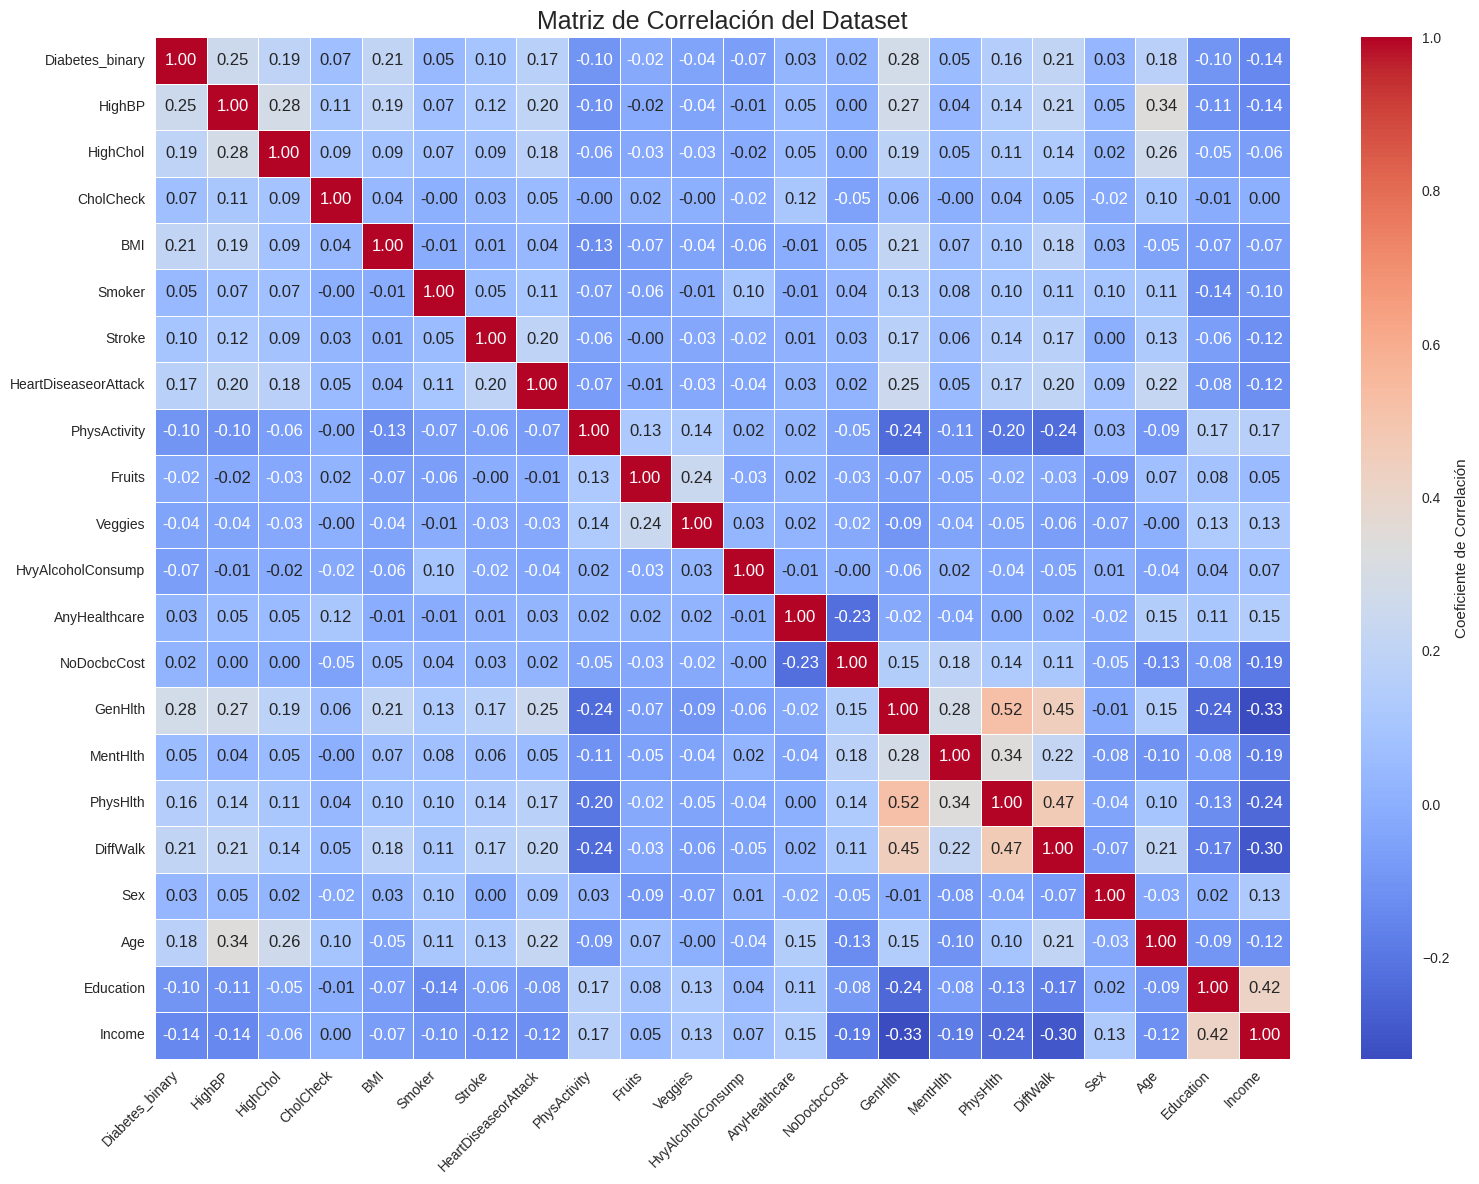

In [ ]:
# Calcula la matriz de correlación
correlation_matrix = data.corr()

# Configura la figura y los ejes
plt.figure(figsize=(16, 12))

# Crea el heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,  # Mostrar los valores
    fmt=".2f",   # Formato de los valores a dos decimales
    cmap="coolwarm", # Esquema de color
    linewidths=.5, # Líneas entre las celdas
    cbar_kws={'label': 'Coeficiente de Correlación'} # Etiqueta de la barra de color
)

plt.title('Matriz de Correlación del Dataset', fontsize=18)
plt.xticks(rotation=45, ha='right') # Rotar etiquetas del eje x
plt.yticks(rotation=0) # No rotar etiquetas del eje y
plt.tight_layout() # Ajustar el layout para evitar solapamiento
plt.show()

En el mapa de correlaciones podemos notar lo siguiente

**Correlaciones Positivas Altas:**

HighBP (Presión Alta) y HighChol (Colesterol Alto) muestran una correlación positiva notable entre sí. Esto indica que las personas con presión alta a por lo general también tienen colesterol alto.
HeartDiseaseorAttack y Stroke tienen una correlación positiva, lo cual es esperado ya que ambas son condiciones cardiovasculares.
DiffWalk (Dificultad para caminar) parece estar positivamente correlacionada con PhysHlth (Salud Física), lo que indica que tener dificultades para caminar se asocia con una peor salud física percibida.
GenHlth (Salud General) muestra correlaciones positivas con PhysHlth y MentHlth (Salud Mental), sugiriendo que la percepción de la salud general está relacionada con la salud física y mental.
Age (Edad) muestra correlaciones positivas con varias condiciones de salud como HighBP, HighChol, HeartDiseaseorAttack, Stroke, DiffWalk, y GenHlth, lo que indica que estas condiciones son comunes a medida que las personas son mas adultas.

**Correlaciones Negativas:**

PhysActivity (Actividad Física) muestra correlaciones negativas con condiciones de salud como HighBP, HighChol, BMI, GenHlth, PhysHlth, MentHlth, DiffWalk. Esto sugiere que ser físicamente activo se asocia con un menor riesgo o severidad de estas condiciones.
Fruits y Veggies (Consumo de frutas y verduras) tienen correlaciones ligeramente negativas con algunas condiciones de salud, lo que podría indicar que una dieta saludable está asociada con un menor riesgo.
Education e Income muestran correlaciones negativas con la variable objetivo Diabetes_binary y otras condiciones de salud. Esto sugiere que niveles más altos de educación e ingresos se asocian con un menor riesgo de diabetes y otras condiciones de salud.

**Correlación con la Variable Objetivo (Diabetes_binary):**

Diabetes_binary tiene correlaciones positivas notables con HighBP, HighChol, BMI, HeartDiseaseorAttack, Stroke, DiffWalk, GenHlth, PhysHlth, y Age. Esto indica que tener diabetes se asocia fuertemente con la presión alta, colesterol alto, un IMC más alto, enfermedades cardíacas, accidentes cerebrovasculares, dificultad para caminar, peor salud general y física, y una mayor edad.
Diabetes_binary muestra correlaciones negativas con PhysActivity, Fruits, Veggies, Education, e Income, lo que sugiere que la actividad física, una dieta saludable, una mayor educación y mayores ingresos se asocian con un menor riesgo de diabetes.
sión de las relaciones en tus datos.

### Distribución de varaibles numéricas importantes

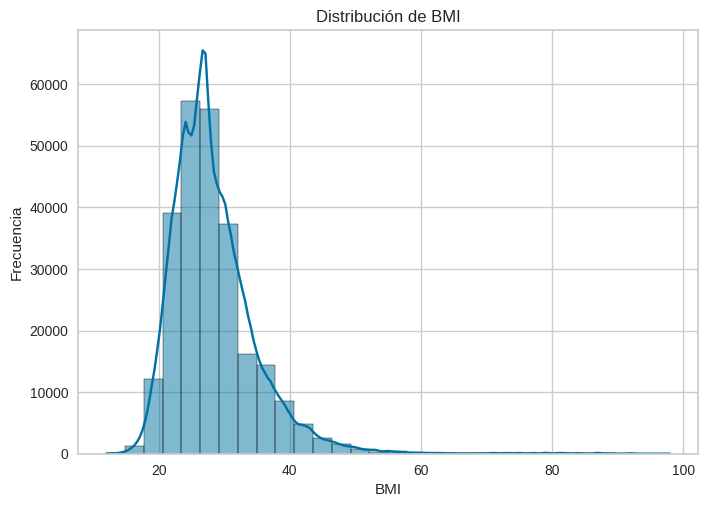

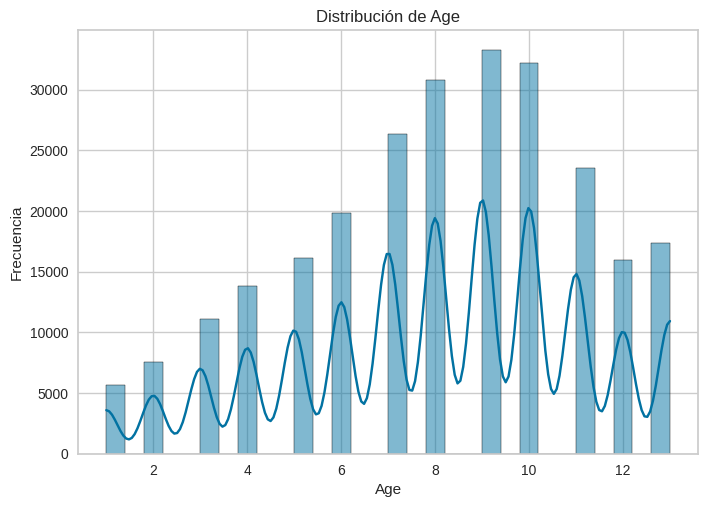

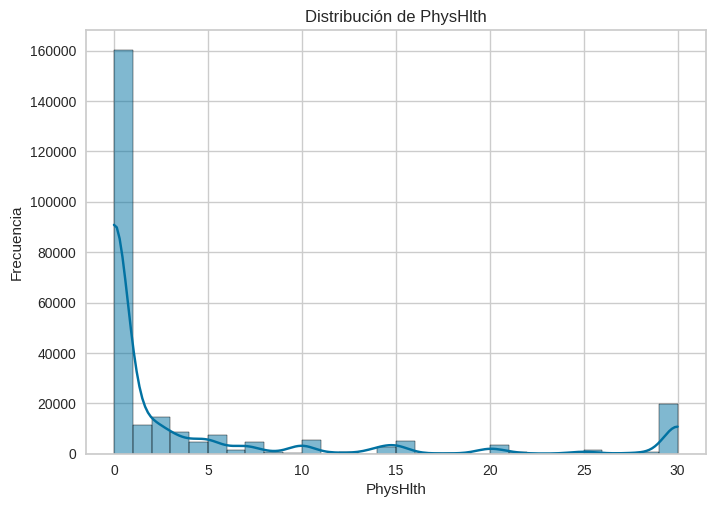

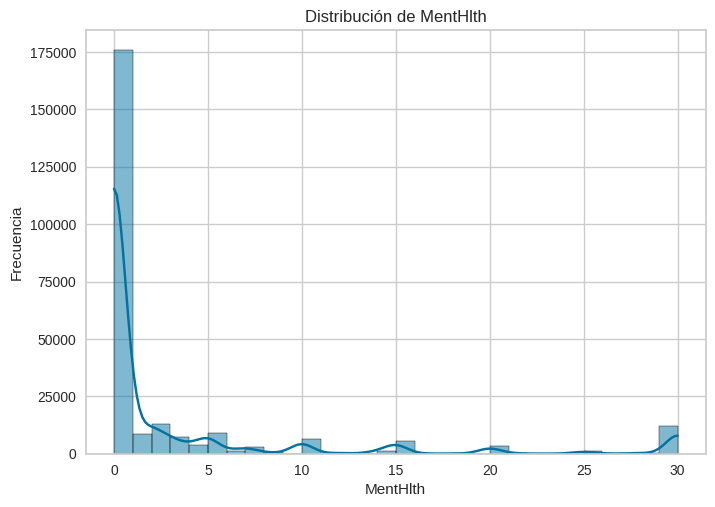

In [ ]:
features = ['BMI', 'Age', 'PhysHlth', 'MentHlth']

for feature in features:
    plt.figure()
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Distribución de {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')
    plt.show()


### Uso de ydata-profiling

In [ ]:
profile = ProfileReport(data, title="Informe EDA Diabetes", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 22/22 [00:11<00:00,  1.99it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-14-b928c589d319>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
<ipython-input-14-b928c589d319>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')


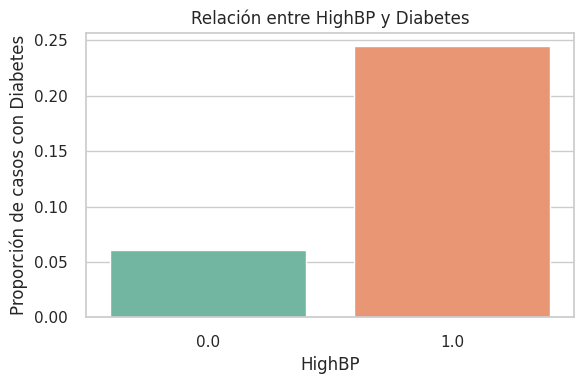

<ipython-input-14-b928c589d319>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
<ipython-input-14-b928c589d319>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')


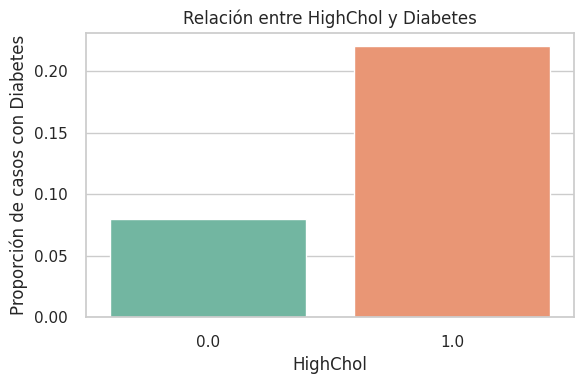

<ipython-input-14-b928c589d319>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
<ipython-input-14-b928c589d319>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')


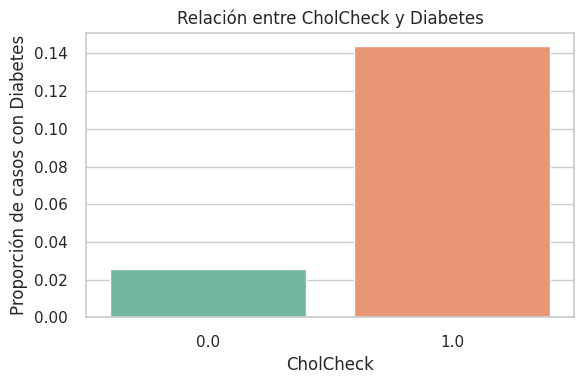

<ipython-input-14-b928c589d319>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=data, palette='coolwarm')


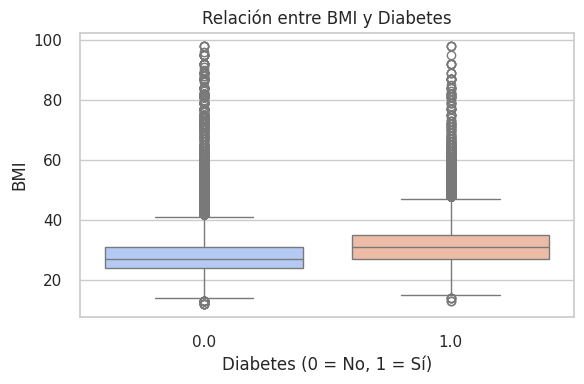

<ipython-input-14-b928c589d319>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
<ipython-input-14-b928c589d319>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')


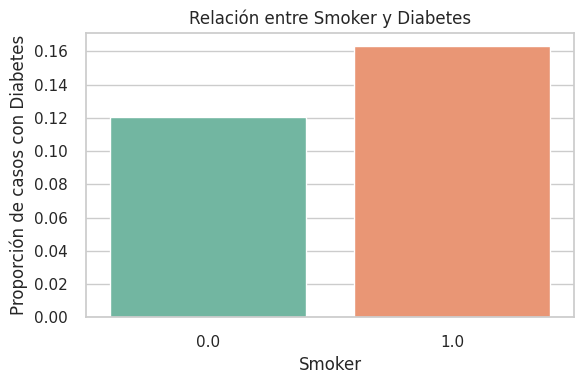

<ipython-input-14-b928c589d319>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
<ipython-input-14-b928c589d319>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')


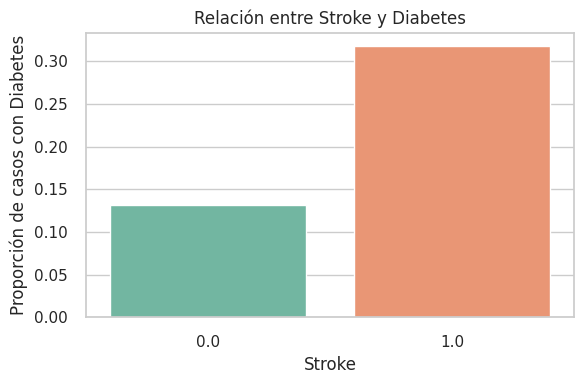

<ipython-input-14-b928c589d319>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
<ipython-input-14-b928c589d319>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')


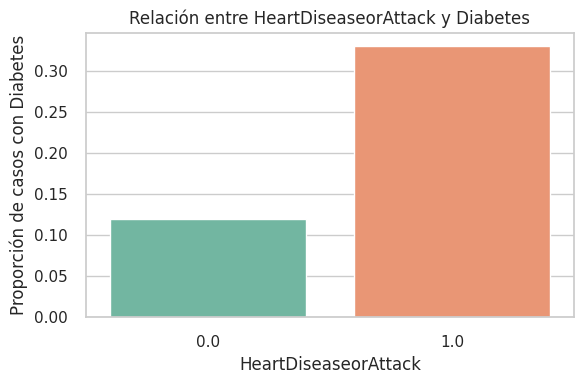

<ipython-input-14-b928c589d319>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
<ipython-input-14-b928c589d319>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')


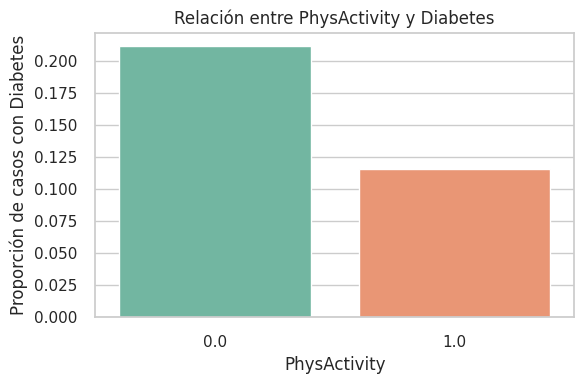

<ipython-input-14-b928c589d319>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
<ipython-input-14-b928c589d319>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')


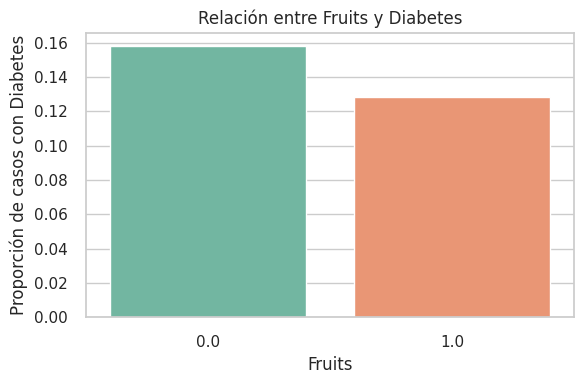

<ipython-input-14-b928c589d319>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
<ipython-input-14-b928c589d319>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')


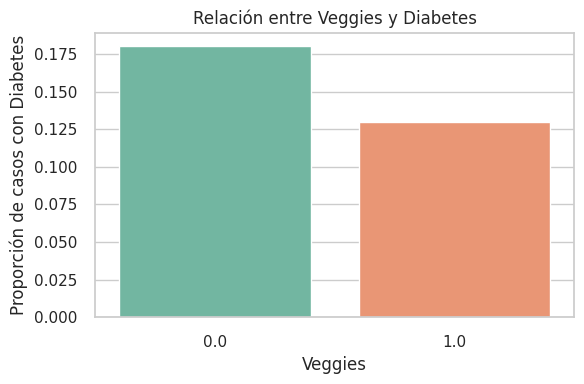

<ipython-input-14-b928c589d319>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
<ipython-input-14-b928c589d319>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')


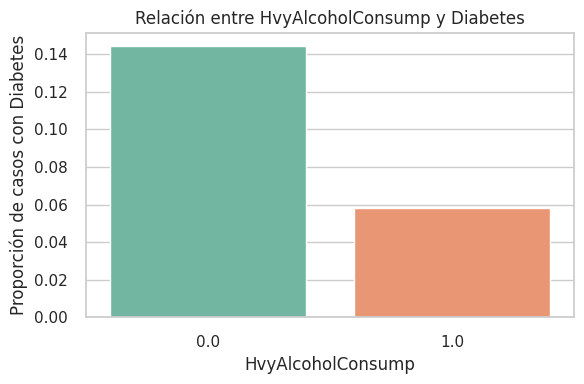

<ipython-input-14-b928c589d319>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
<ipython-input-14-b928c589d319>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')


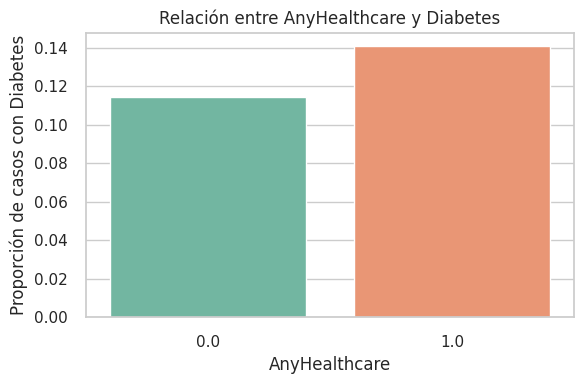

<ipython-input-14-b928c589d319>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
<ipython-input-14-b928c589d319>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')


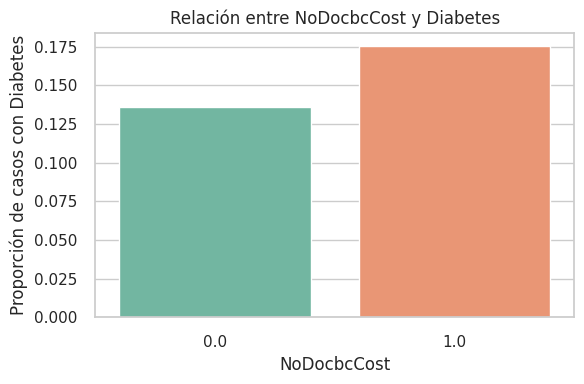

<ipython-input-14-b928c589d319>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
<ipython-input-14-b928c589d319>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')


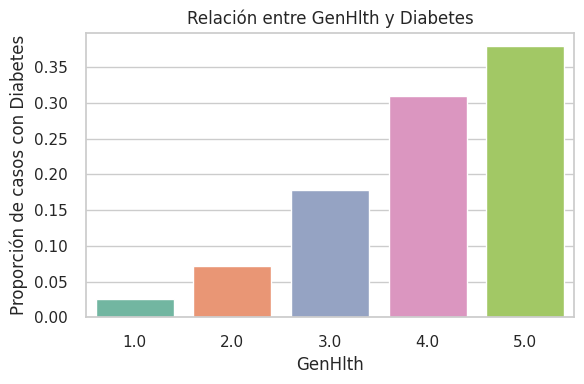

<ipython-input-14-b928c589d319>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=data, palette='coolwarm')


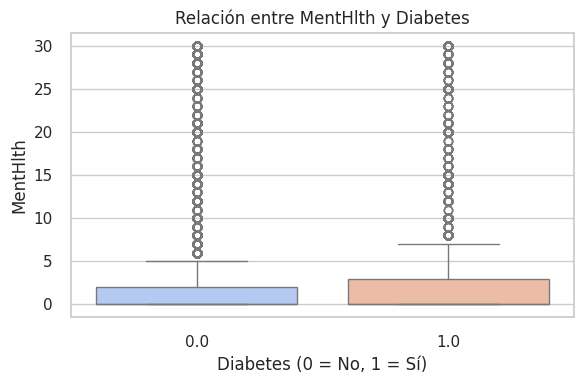

<ipython-input-14-b928c589d319>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=data, palette='coolwarm')


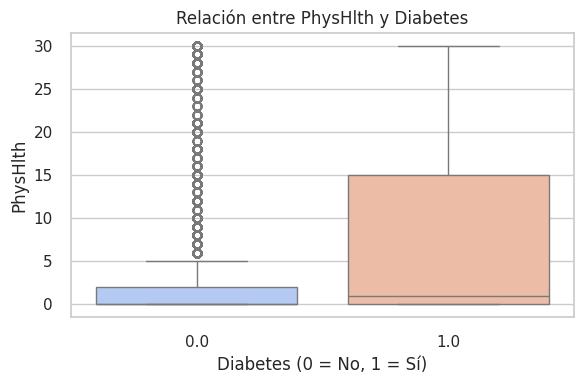

<ipython-input-14-b928c589d319>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
<ipython-input-14-b928c589d319>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')


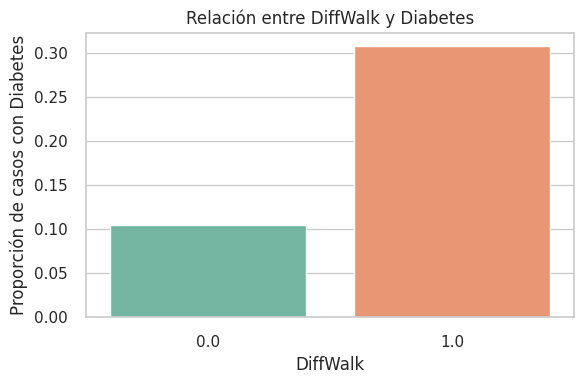

<ipython-input-14-b928c589d319>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
<ipython-input-14-b928c589d319>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')


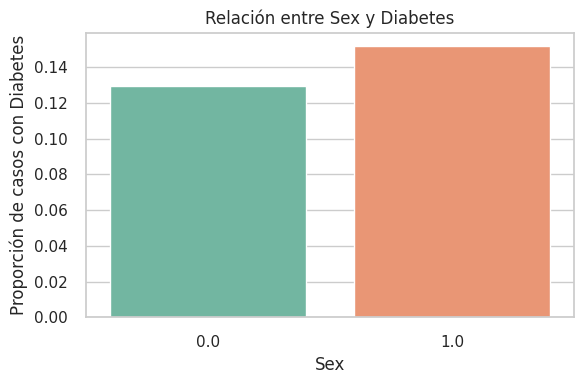

<ipython-input-14-b928c589d319>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=data, palette='coolwarm')


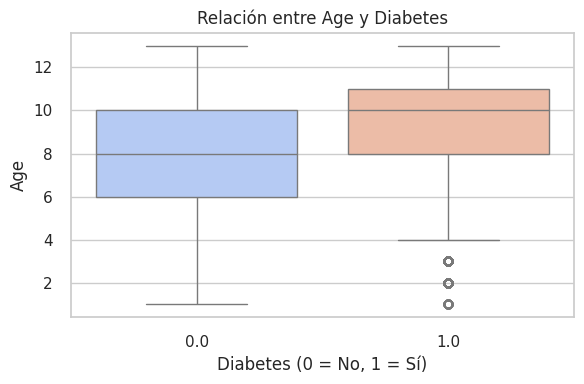

<ipython-input-14-b928c589d319>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
<ipython-input-14-b928c589d319>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')


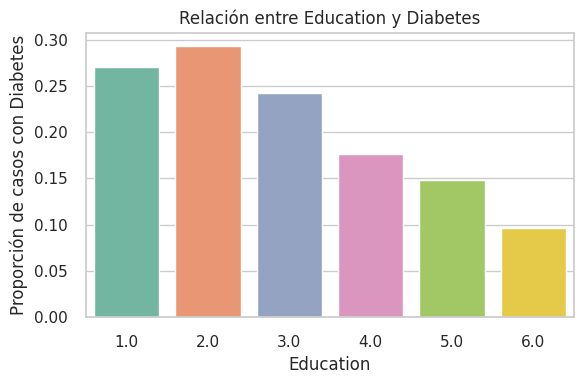

<ipython-input-14-b928c589d319>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
<ipython-input-14-b928c589d319>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')


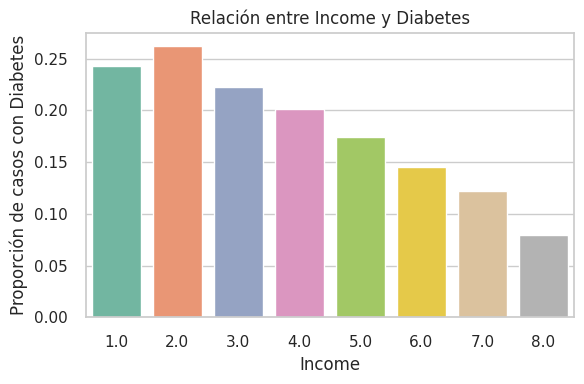

In [ ]:
# Separar variables predictoras
target = 'Diabetes_binary'
features = [col for col in data.columns if col != target]

# Crear gráficas según el tipo de variable
for col in features:
    plt.figure(figsize=(6, 4))

    if data[col].nunique() <= 10:  # Para variables categóricas o discretas
        sns.barplot(x=col, y=target, data=data, ci=None, palette='Set2')
        plt.ylabel('Proporción de casos con Diabetes')
    else:  # Para variables continuas
        sns.boxplot(x=target, y=col, data=data, palette='coolwarm')
        plt.ylabel(col)
        plt.xlabel('Diabetes (0 = No, 1 = Sí)')

    plt.title(f'Relación entre {col} y Diabetes')
    plt.tight_layout()
    plt.show()

### Exportación de los datos limpios

In [ ]:
# Specify the filename for the cleaned data
output_filename = 'cleaned_diabetes_data.csv'

# Export the DataFrame to a CSV file
data.to_csv(output_filename, index=False)

print(f"Cleaned data exported successfully to {output_filename}")

Cleaned data exported successfully to cleaned_diabetes_data.csv


## Conclusiones

Conclusiones del Análisis Exploratorio de Datos (EDA)
El análisis exploratorio del conjunto de datos diabetes_binary_health_indicators_BRFSS2015.csv, permitió comprender la estructura, calidad y patrones internos de los datos utilizados para predecir la presencia de diabetes en personas.

A partir del análisis se destacan las siguientes conclusiones clave:

1. Distribución de la variable objetivo
La variable Diabetes_binary está desbalanceada, con aproximadamente 14% de casos positivos (1) y 86% negativos (0).

Este desbalance se tendrá en cuenta en el modelado utilizando técnicas como class_weight='balanced' o SMOTE.

2. Calidad de los datos
No se encontraron valores nulos ni errores evidentes.

Se detectaron duplicados, los cuales fueron eliminados como parte de la limpieza.

3. Relaciones con la variable objetivo
Se observaron relaciones significativas entre Diabetes_binary y múltiples variables:

Variables clínicas fuertemente asociadas:

HighBP (presión alta), HighChol (colesterol alto), HeartDiseaseorAttack, Stroke.

BMI mostró un aumento notable en personas con diabetes (mediana > 30).

Factores funcionales relevantes:

DiffWalk, PhysHlth, GenHlth presentan fuertes diferencias en los grupos con y sin diabetes.

Estilo de vida:

Actividad física (PhysActivity), consumo de frutas y vegetales (Fruits, Veggies) están asociados a menor riesgo.

El consumo excesivo de alcohol (HvyAlcoholConsump) mostró una relación inversa inesperada, posiblemente influida por edad o diagnóstico previo.

Factores sociales y demográficos:

Edad (Age) muestra una clara relación directa con la diabetes.

Bajos niveles de educación e ingreso (Education, Income) están fuertemente asociados con mayor riesgo.

El sexo masculino tiene una leve mayor proporción de casos positivos.

4. Implicaciones para el modelo
El conjunto de datos está listo para ser modelado sin necesidad de imputaciones.

Se identificarán posibles variables con poca contribución para eliminarlas durante el preprocesamiento.

Las relaciones no lineales observadas (ej. entre edad, salud funcional y diabetes) justifican el uso de modelos complejos como Random Forest o XGBoost además de la regresión logística como modelo base.

Conclusión general
El dataset es adecuado para aplicar técnicas de aprendizaje automático de clasificación. Las variables predictoras tienen significado clínico y social, y muestran patrones claros frente a la variable objetivo. El análisis exploratorio ha revelado factores clave para la predicción, riesgos sociales evidentes y variables relevantes que serán utilizadas para entrenar y validar modelos en la siguiente etapa.